# Back testing results from models built
---

# 1. Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from keras.models import load_model

In [2]:
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.4.1


---

# 2. Choose company and timeline

In [3]:
ticker = "MSFT"
month = "1"
path = f"../TDL_Project_Data/{ticker}_year1_month{month}.csv"
stock = pd.read_csv(path, parse_dates=['time'])

In [4]:
stock.head()

,time,open,high,low,close,volume,company,price_1_min_ahead,price_2_min_ahead,price_3_min_ahead,...,EMA,MACD,MACD_Signal,change,gain,loss,avg_gain,avg_loss,rs,RSI
0,2021-04-23 15:53:00,260.93,261.11,260.890,261.0000,105102,MSFT,260.93,261.18,261.05,...,261.146603,-0.133621,-0.145338,0.0700,0.07,0.0000,0.029490,0.063490,0.464483,31.716498
1,2021-04-23 15:52:00,260.81,260.98,260.810,260.9100,82132,MSFT,261.00,260.93,261.18,...,261.124069,-0.136377,-0.143545,-0.0900,0.00,0.0900,0.028015,0.064815,0.432235,30.179035
2,2021-04-23 15:51:00,261.05,261.17,260.800,260.8000,136199,MSFT,260.91,261.00,260.93,...,261.093205,-0.145757,-0.143988,-0.1100,0.00,0.1100,0.026615,0.067075,0.396792,28.407387
3,2021-04-23 15:50:00,261.01,261.09,261.005,261.0400,50257,MSFT,260.80,260.91,261.00,...,261.088138,-0.132300,-0.141650,0.2400,0.24,0.0000,0.037284,0.063721,0.585113,36.913021
4,2021-04-23 15:49:00,261.02,261.08,260.990,260.9946,56559,MSFT,261.04,260.80,260.91,...,261.079230,-0.123870,-0.138094,-0.0454,0.00,0.0454,0.035420,0.062805,0.563965,36.059951


---

# 3. Visualize compnay's stock data

## 3.1. Sample data of Stock price, volume, Simple moving average and Bollinger bands

No handles with labels found to put in legend.


Text(0.5, 1.0, '')

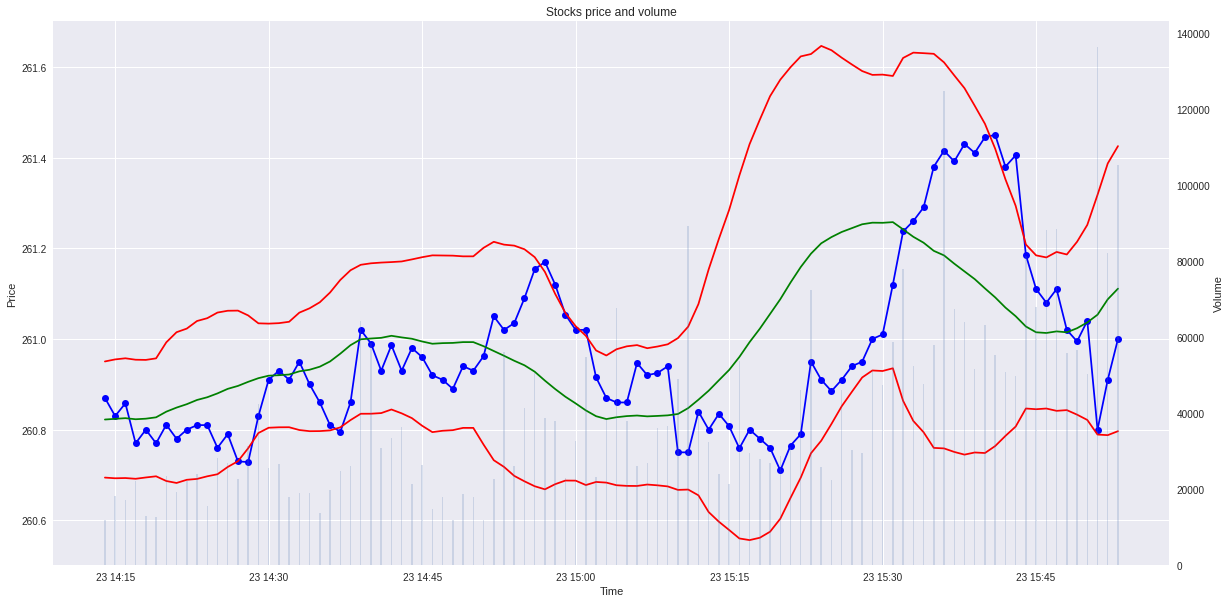

In [5]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], stock['SMA'][:100], label='Simple moving Average', color='g')

ax1.plot(stock['time'][:100], stock['up_band_2'][:100], label='', color='r')
ax1.plot(stock['time'][:100], stock['low_band_2'][:100], label='positive sentiment percentage', color='r')
    
ax2.set_xlabel("Time")
ax2.set_ylabel("Volume")
ax2.set_title(f'Stocks price and volume')
# ax1.set_ylim(0, 100)
ax2.bar(stock['time'][:100], stock['volume'][:100], width=0.0001, alpha=0.2)
ax2.grid(b=False)

ax2.legend()
plt.title("")

## 3.2. RSI, MACD and MACD Signal Indicators of the stock

Text(0.5, 1.0, 'MACD and MACD Signal')

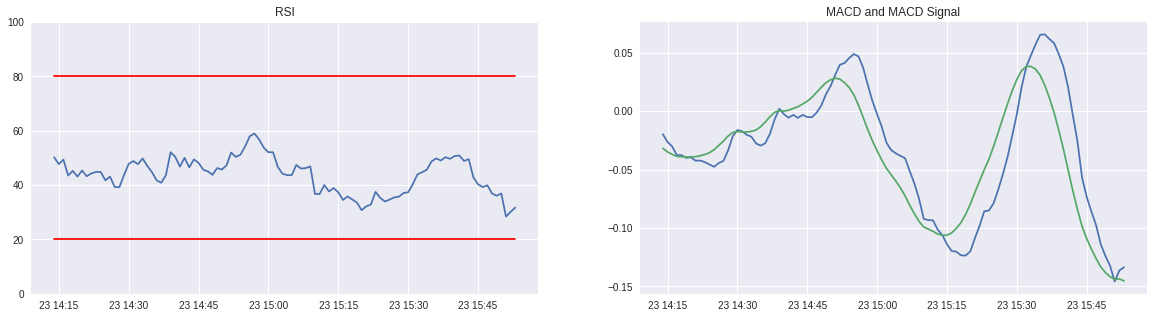

In [6]:
fig = plt.figure(figsize=(20, 5))
    
ax1 = plt.subplot2grid((1,2),(0,0))
labels = ['', '']
plt.plot(stock['time'][:100], stock['RSI'][:100])
plt.plot(stock['time'][:100], [20 for i in range(100)], color='r')
plt.plot(stock['time'][:100], [80 for i in range(100)], color='r')
plt.ylim(0, 100)
plt.title(f'RSI')
    
ax2 = plt.subplot2grid((1,2), (0, 1))
plt.plot(stock['time'][:100], stock['MACD'][:100])
plt.plot(stock['time'][:100], stock['MACD_Signal'][:100])
# plt.plot(stock['time'][:100], [20 for i in range(100)])
# plt.plot(stock['time'][:100], [80 for i in range(100)])
# plt.ylim(0, 100)
plt.title(f'MACD and MACD Signal')

---

# 4. Generate predictions on data using all models

In [7]:
models_acc = {}

## 4.1. Regression models

### 4.1.1 Regression models preprocessing

In [8]:
scaler = StandardScaler()

In [9]:
X = stock.copy()
X.drop(
    ['time', 'price_1_min_ahead', 'price_2_min_ahead', 'price_3_min_ahead', 'price_5_min_ahead', 'price_10_min_ahead', 'company', 'change', 'gain', 'loss', 'avg_gain', 'avg_loss', 'rs'],
    axis='columns',
    inplace=True
)
X.head()

,open,high,low,close,volume,SMA,up_band_1,up_band_2,up_band_3,low_band_1,low_band_2,low_band_3,EMA,MACD,MACD_Signal,RSI
0,260.93,261.11,260.890,261.0000,105102,261.110990,261.268152,261.425314,261.582476,260.953828,260.796666,260.639504,261.146603,-0.133621,-0.145338,31.716498
1,260.81,260.98,260.810,260.9100,82132,261.087490,261.237277,261.387063,261.536850,260.937703,260.787917,260.638130,261.124069,-0.136377,-0.143545,30.179035
2,261.05,261.17,260.800,260.8000,136199,261.053495,261.185650,261.317806,261.449961,260.921340,260.789184,260.657029,261.093205,-0.145757,-0.143988,28.407387
3,261.01,261.09,261.005,261.0400,50257,261.036495,261.144011,261.251526,261.359042,260.928979,260.821464,260.713948,261.088138,-0.132300,-0.141650,36.913021
4,261.02,261.08,260.990,260.9946,56559,261.023725,261.119020,261.214315,261.309610,260.928430,260.833135,260.737840,261.079230,-0.123870,-0.138094,36.059951


In [10]:
X_matrix = X.values
X_matrix.shape
X_matrix = scaler.fit_transform(X_matrix)

In [11]:
print("Before reshaping: ", X_matrix.shape)
X_matrix = X_matrix.reshape(X_matrix.shape[0], X_matrix.shape[1], 1)
print("After reshaping: ", X_matrix.shape)

Before reshaping:  (8718, 16)
After reshaping:  (8718, 16, 1)


In [12]:
y = np.array(stock['price_1_min_ahead'])
print("Before reshaping: ", y.shape)
y = y.reshape(y.shape[0], 1)
print("After reshaping: ", y.shape)

Before reshaping:  (8718,)
After reshaping:  (8718, 1)


In [13]:
y = scaler.fit_transform(y)

In [14]:
def get_trades(actual_prices, target_prices):

    pred_labels = []
    for price in actual_prices - target_prices:
        # print(price)
        if price < 0:
            pred_labels.append(1)
        else:
            pred_labels.append(0)
    
    return pred_labels

### 4.1.2. LSTM Model 1

In [15]:
LSTM_model = load_model('./SavedModels/LSTM_best_model_1_59_15.h5')

In [16]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [17]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [18]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.01647408177305311
Mean Squared Error: 0.0006203654376524197
Root Mean Squared Error: 0.024907136279637202


In [19]:
LSTM_model_predictions_prices = scaler.inverse_transform(LSTM_model_predictions)
LSTM_model_predictions_prices

array([[261.05228],
       [260.88507],
       [260.92007],
       ...,
       [234.72513],
       [234.7589 ],
       [234.83775]], dtype=float32)

In [20]:
y = scaler.inverse_transform(y)
y

array([[260.93],
       [261.  ],
       [260.91],
       ...,
       [235.2 ],
       [234.66],
       [235.21]])

In [21]:
print('FOR ACTUAL PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions_prices))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions_prices))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions_prices)))

FOR ACTUAL PRICES
Mean Absolute Error: 0.16859246265527789
Mean Squared Error: 0.06497129083187024
Root Mean Squared Error: 0.2548946661502948


In [22]:
X_pred_labels = get_trades(LSTM_model_predictions_prices.reshape(LSTM_model_predictions_prices.shape[0])[:-1], LSTM_model_predictions_prices.reshape(LSTM_model_predictions_prices.shape[0])[1:])
X_target_labels = get_trades(y.reshape(y.shape[0])[:-1], y.reshape(y.shape[0])[1:])

In [23]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(X_pred_labels, X_target_labels))
print('PRECISION: ', metrics.precision_score(X_pred_labels, X_target_labels))
print('RECALL: ', metrics.recall_score(X_pred_labels, X_target_labels))

METRICS ON PREDICTIONS
ACCURACY:  0.5950441665710681
PRECISION:  0.5992831541218638
RECALL:  0.575097454712222


In [24]:
models_acc['LSTM_Model_1'] = metrics.accuracy_score(X_pred_labels, X_target_labels)
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681}


No handles with labels found to put in legend.


Text(0.5, 1.0, '')

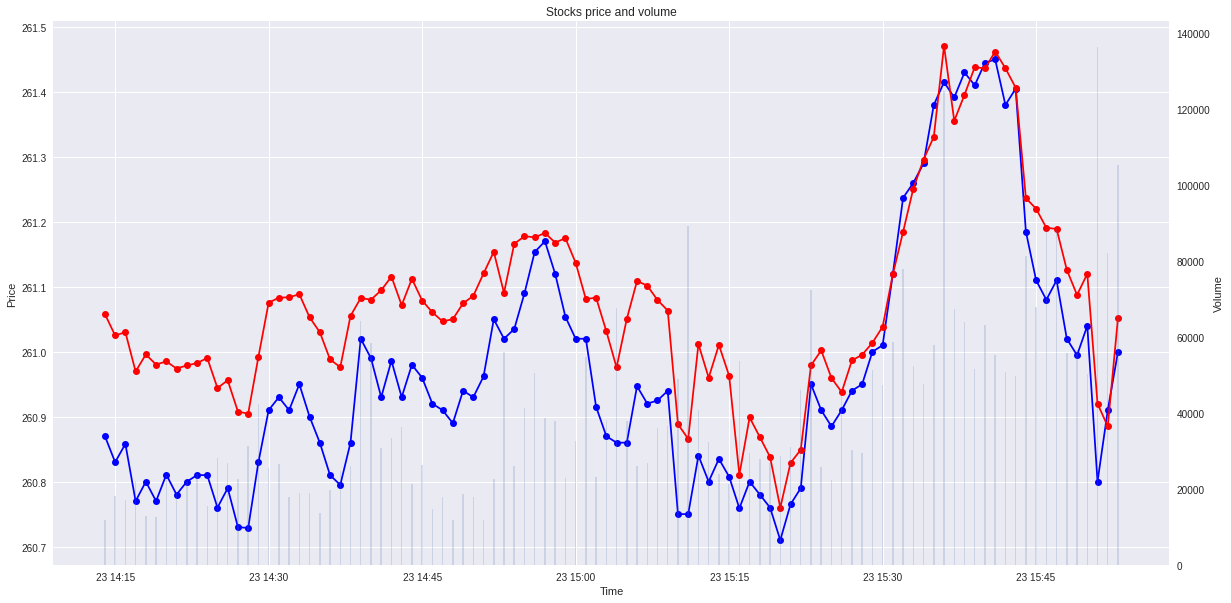

In [25]:
# Visualize predictions
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis

ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='r')

ax2.set_xlabel("Time")
ax2.set_ylabel("Volume")
ax2.set_title(f'Stocks price and volume')
# ax1.set_ylim(0, 100)
ax2.bar(stock['time'][:100], stock['volume'][:100], width=0.0001, alpha=0.2)
ax2.grid(b=False)

ax2.legend()
plt.title("")

Text(0.5, 1.0, '')

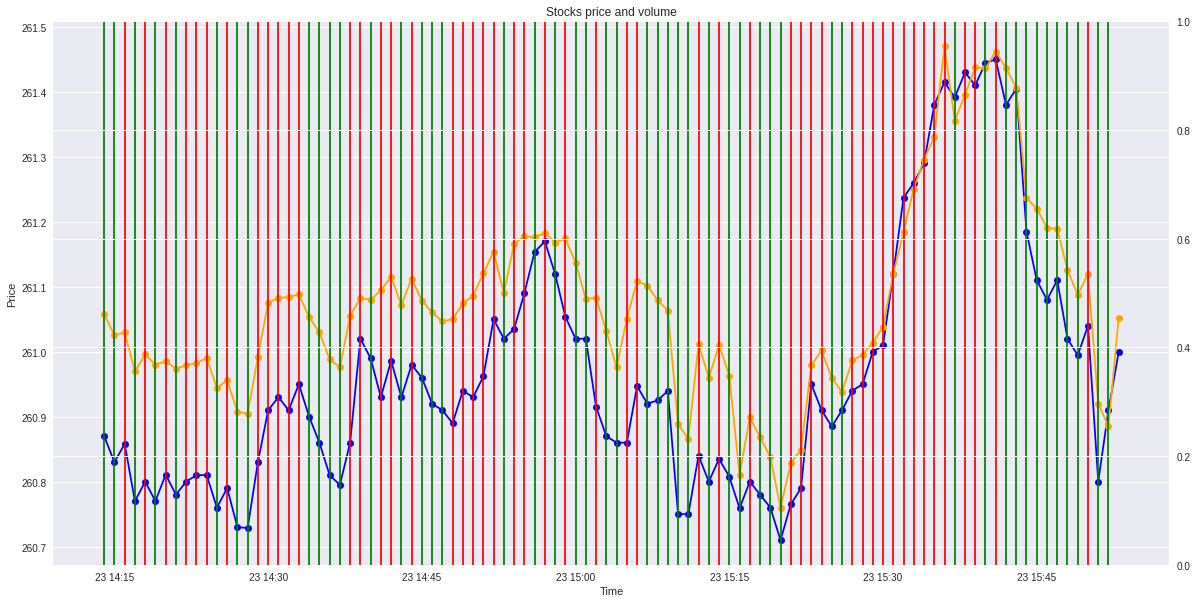

In [26]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='orange')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if X_pred_labels[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

### 4.1.3. LSTM Model 2

In [27]:
LSTM_model = load_model('./SavedModels/LSTM_best_model_2_55.h5')

In [28]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [29]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [30]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 249.75894534452135
Mean Squared Error: 62464.69236694112
Root Mean Squared Error: 249.92937475803262


In [31]:
LSTM_model_predictions_prices = scaler.inverse_transform(LSTM_model_predictions)
LSTM_model_predictions_prices

array([[261.08304],
       [261.11365],
       [261.0406 ],
       ...,
       [234.85611],
       [235.03542],
       [235.06958]], dtype=float32)

In [32]:
y = scaler.inverse_transform(y)
y

array([[2920.07918051],
       [2920.79554651],
       [2919.87450451],
       ...,
       [2656.76350732],
       [2651.23725534],
       [2656.86584532]])

In [33]:
print('FOR ACTUAL PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions_prices))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions_prices))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions_prices)))

FOR ACTUAL PRICES
Mean Absolute Error: 2555.983086863253
Mean Squared Error: 6541968.569743325
Root Mean Squared Error: 2557.727227392187


In [34]:
X_pred_labels = get_trades(LSTM_model_predictions_prices.reshape(LSTM_model_predictions_prices.shape[0])[:-1], LSTM_model_predictions_prices.reshape(LSTM_model_predictions_prices.shape[0])[1:])
X_target_labels = get_trades(y.reshape(y.shape[0])[:-1], y.reshape(y.shape[0])[1:])

In [35]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(X_pred_labels, X_target_labels))
print('PRECISION: ', metrics.precision_score(X_pred_labels, X_target_labels))
print('RECALL: ', metrics.recall_score(X_pred_labels, X_target_labels))

METRICS ON PREDICTIONS
ACCURACY:  0.5950441665710681
PRECISION:  0.5945041816009558
RECALL:  0.5757926405924555


In [36]:
models_acc['LSTM_Model_2'] = metrics.accuracy_score(X_pred_labels, X_target_labels)
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681, 'LSTM_Model_2': 0.5950441665710681}


No handles with labels found to put in legend.


Text(0.5, 1.0, '')

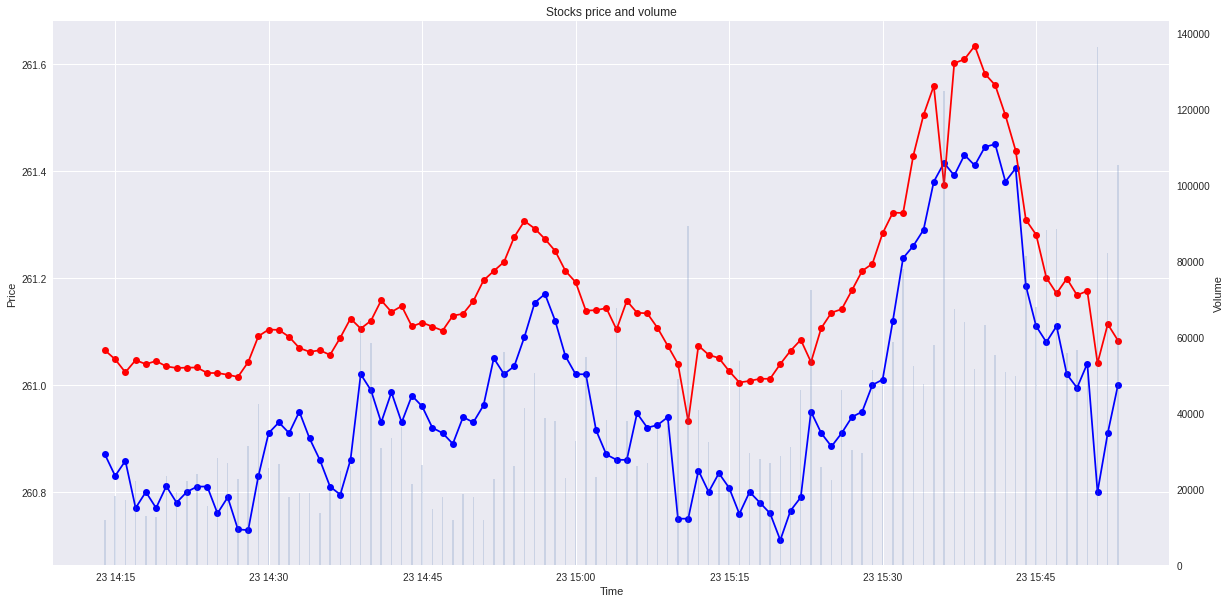

In [37]:
# Visualize predictions
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis

ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='r')

ax2.set_xlabel("Time")
ax2.set_ylabel("Volume")
ax2.set_title(f'Stocks price and volume')
# ax1.set_ylim(0, 100)
ax2.bar(stock['time'][:100], stock['volume'][:100], width=0.0001, alpha=0.2)
ax2.grid(b=False)

ax2.legend()
plt.title("")

Text(0.5, 1.0, '')

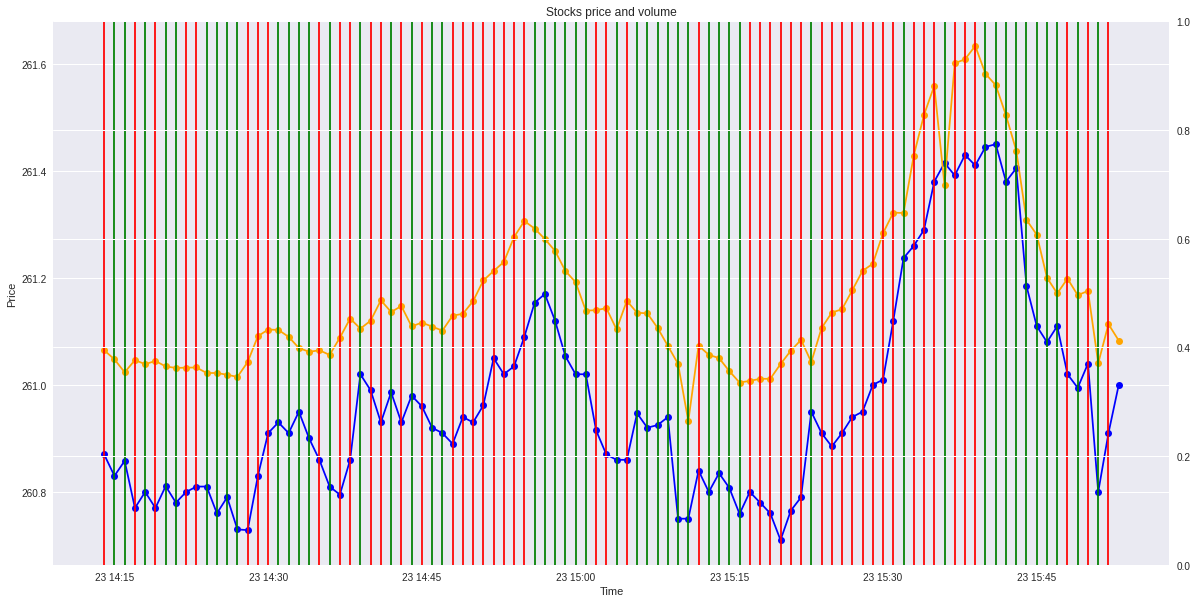

In [38]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='orange')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if X_pred_labels[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

### 4.1.4. LSTM Model 3

In [39]:
LSTM_model = load_model('./SavedModels/LSTM_best_model_3_54_9.h5')

In [40]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16, 100)           40800     
_________________________________________________________________
lstm_4 (LSTM)                (None, 16, 64)            42240     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 116,129
Trainable params: 116,129
Non-trainable params: 0
_________________________________________________________________


In [41]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [42]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 2805.9099977886253
Mean Squared Error: 7883887.909781846
Root Mean Squared Error: 2807.826189382428


In [43]:
LSTM_model_predictions_prices = scaler.inverse_transform(LSTM_model_predictions)
LSTM_model_predictions_prices

array([[261.0966 ],
       [261.03226],
       [260.94955],
       ...,
       [234.73264],
       [234.854  ],
       [234.90019]], dtype=float32)

In [44]:
y = scaler.inverse_transform(y)
y

array([[30133.27998017],
       [30140.61112649],
       [30131.18536693],
       ...,
       [27438.56005219],
       [27382.00549482],
       [27439.60735881]])

In [45]:
print('FOR ACTUAL PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions_prices))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions_prices))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions_prices)))

FOR ACTUAL PRICES
Mean Absolute Error: 28715.12164709067
Mean Squared Error: 825684798.3176801
Root Mean Squared Error: 28734.73156856838


In [46]:
X_pred_labels = get_trades(LSTM_model_predictions_prices.reshape(LSTM_model_predictions_prices.shape[0])[:-1], LSTM_model_predictions_prices.reshape(LSTM_model_predictions_prices.shape[0])[1:])
X_target_labels = get_trades(y.reshape(y.shape[0])[:-1], y.reshape(y.shape[0])[1:])

In [47]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(X_pred_labels, X_target_labels))
print('PRECISION: ', metrics.precision_score(X_pred_labels, X_target_labels))
print('RECALL: ', metrics.recall_score(X_pred_labels, X_target_labels))

METRICS ON PREDICTIONS
ACCURACY:  0.6004359297923597
PRECISION:  0.5913978494623656
RECALL:  0.5826271186440678


In [48]:
models_acc['LSTM_Model_3'] = metrics.accuracy_score(X_pred_labels, X_target_labels)
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681, 'LSTM_Model_2': 0.5950441665710681, 'LSTM_Model_3': 0.6004359297923597}


No handles with labels found to put in legend.


Text(0.5, 1.0, '')

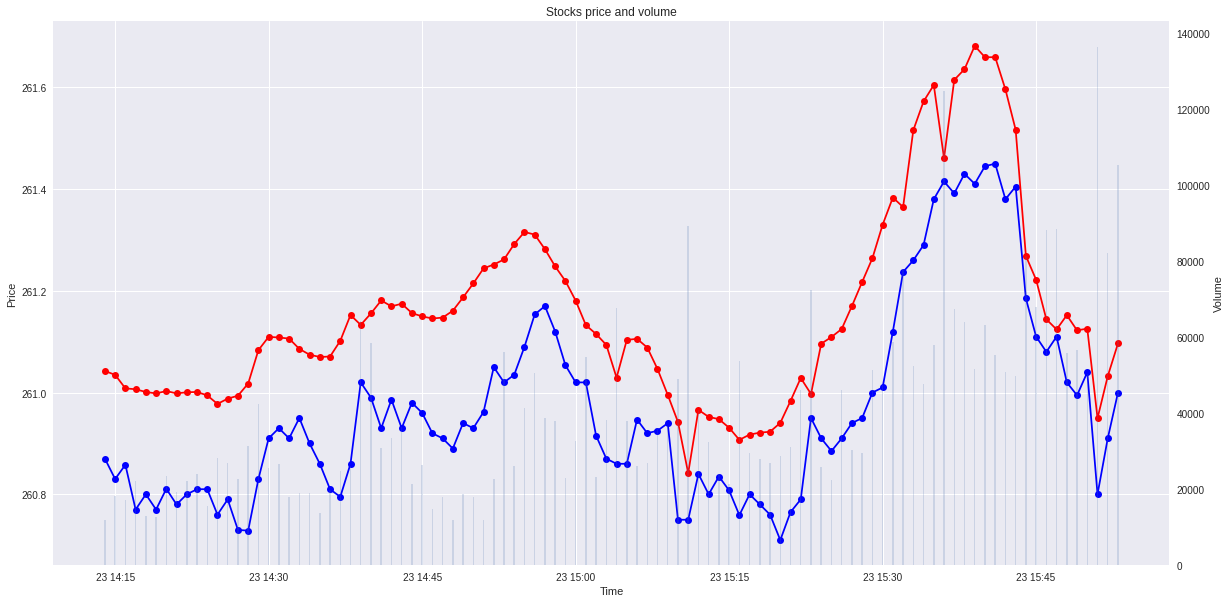

In [49]:
# Visualize predictions
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis

ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='r')

ax2.set_xlabel("Time")
ax2.set_ylabel("Volume")
ax2.set_title(f'Stocks price and volume')
# ax1.set_ylim(0, 100)
ax2.bar(stock['time'][:100], stock['volume'][:100], width=0.0001, alpha=0.2)
ax2.grid(b=False)

ax2.legend()
plt.title("")

Text(0.5, 1.0, '')

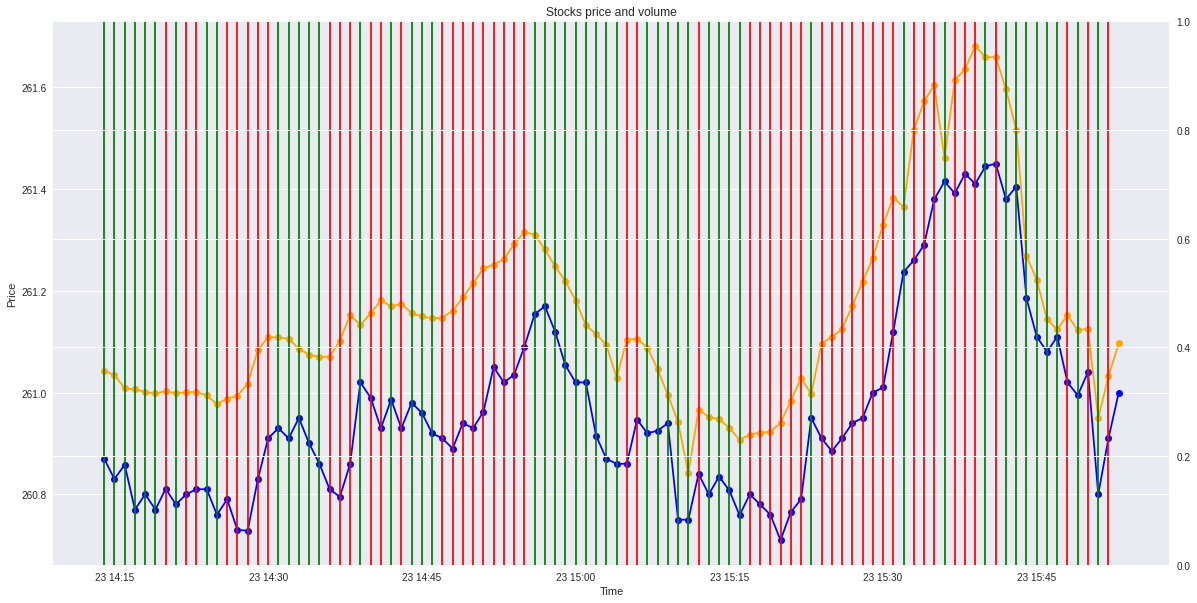

In [50]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='orange')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if X_pred_labels[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

### 4.1.5. Bidirectional LSTM Model 1

In [51]:
LSTM_model = load_model('./SavedModels/BI_LSTM_best_model_1.h5')

In [52]:
LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 16, 100)           40800     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16, 128)           84480     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 174,753
Trainable params: 174,753
Non-trainable params: 0
_________________________________________________________________


In [53]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [54]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 28964.896687478653
Mean Squared Error: 840111904.1365681
Root Mean Squared Error: 28984.683957852085


In [55]:
LSTM_model_predictions_prices = scaler.inverse_transform(LSTM_model_predictions)
LSTM_model_predictions_prices

array([[260.22522],
       [260.29395],
       [260.0096 ],
       ...,
       [235.08322],
       [235.14952],
       [235.16719]], dtype=float32)

In [56]:
y = scaler.inverse_transform(y)
y

array([[308627.73346562],
       [308702.75895065],
       [308606.29761275],
       ...,
       [281050.50875167],
       [280471.74072425],
       [281061.2266781 ]])

In [57]:
print('FOR ACTUAL PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions_prices))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions_prices))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions_prices)))

FOR ACTUAL PRICES
Mean Absolute Error: 296420.95880703646
Mean Squared Error: 87985475701.782
Root Mean Squared Error: 296623.457773963


In [58]:
X_pred_labels = get_trades(LSTM_model_predictions_prices.reshape(LSTM_model_predictions_prices.shape[0])[:-1], LSTM_model_predictions_prices.reshape(LSTM_model_predictions_prices.shape[0])[1:])
X_target_labels = get_trades(y.reshape(y.shape[0])[:-1], y.reshape(y.shape[0])[1:])

In [59]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(X_pred_labels, X_target_labels))
print('PRECISION: ', metrics.precision_score(X_pred_labels, X_target_labels))
print('RECALL: ', metrics.recall_score(X_pred_labels, X_target_labels))

METRICS ON PREDICTIONS
ACCURACY:  0.6279683377308707
PRECISION:  0.619115890083632
RECALL:  0.6110849056603773


In [60]:
models_acc['Bi_LSTM_Model_1'] = metrics.accuracy_score(X_pred_labels, X_target_labels)
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681, 'LSTM_Model_2': 0.5950441665710681, 'LSTM_Model_3': 0.6004359297923597, 'Bi_LSTM_Model_1': 0.6279683377308707}


No handles with labels found to put in legend.


Text(0.5, 1.0, '')

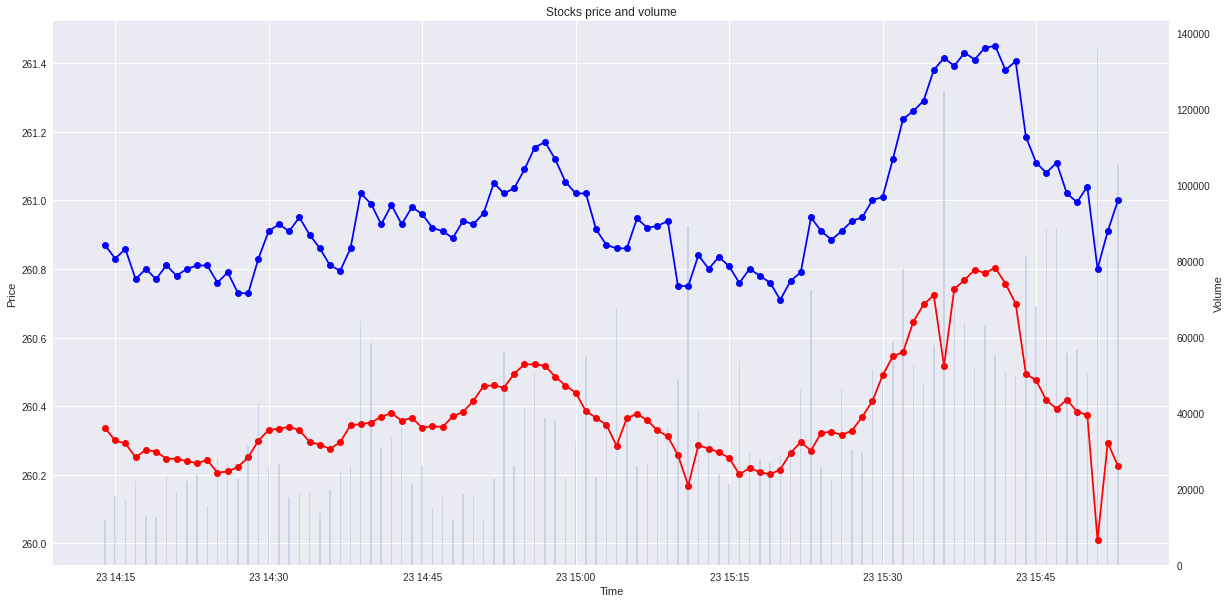

In [61]:
# Visualize predictions
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis

ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='r')

ax2.set_xlabel("Time")
ax2.set_ylabel("Volume")
ax2.set_title(f'Stocks price and volume')
# ax1.set_ylim(0, 100)
ax2.bar(stock['time'][:100], stock['volume'][:100], width=0.0001, alpha=0.2)
ax2.grid(b=False)

ax2.legend()
plt.title("")

Text(0.5, 1.0, '')

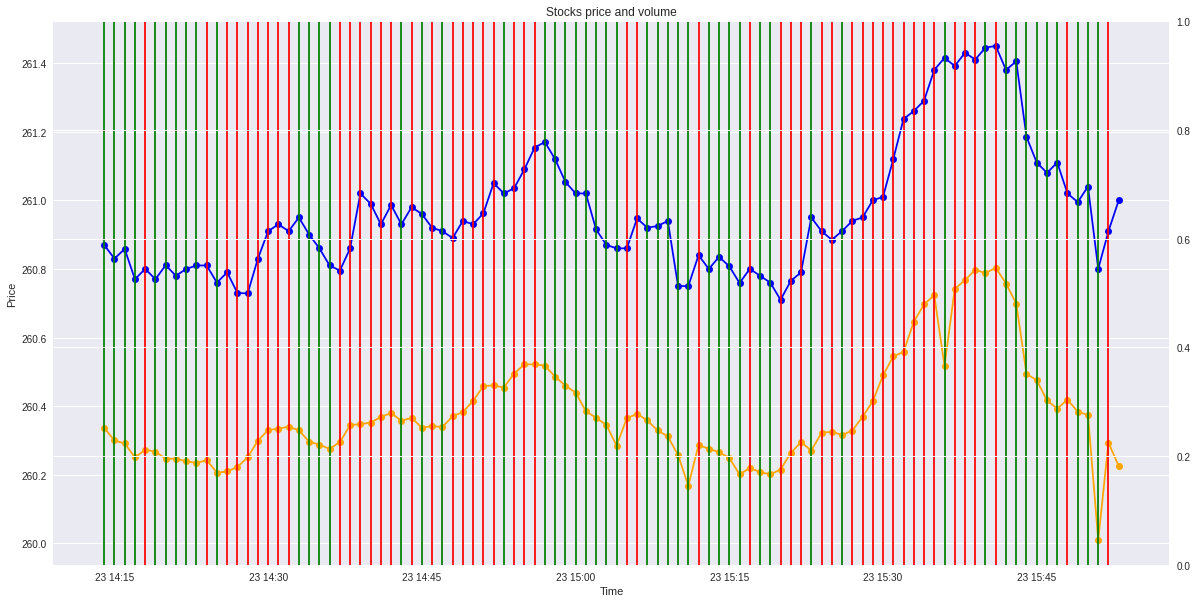

In [62]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], LSTM_model_predictions_prices[:100], label='Predcitions', marker = 'o', color='orange')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if X_pred_labels[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2. LSTM Classifiers

## 4.2.1 Classifiers preprocessing

In [63]:
Trades_1_min = get_trades(stock['close'], stock['price_1_min_ahead'])

In [64]:
y = np.array(Trades_1_min)
y

array([0, 1, 1, ..., 1, 0, 0])

## 4.2.2. LSTM Classifier 1

In [65]:
LSTM_model = load_model('./SavedModels/LSTM_Classifier_best_model_2_68.h5')

In [66]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [67]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [68]:
LSTM_model_predictions

array([[0.6441412 ],
       [0.66525733],
       [0.67387617],
       ...,
       [0.48026577],
       [0.37954053],
       [0.17001936]], dtype=float32)

In [69]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [70]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.40985060615854324
Mean Squared Error: 0.20269847012047448
Root Mean Squared Error: 0.4502204683490906


In [71]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [72]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.6819224592796513
PRECISION:  0.6347542511064523
RECALL:  0.693384223918575


In [73]:
models_acc['LSTM_Classifier_Model_1'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681, 'LSTM_Model_2': 0.5950441665710681, 'LSTM_Model_3': 0.6004359297923597, 'Bi_LSTM_Model_1': 0.6279683377308707, 'LSTM_Classifier_Model_1': 0.6819224592796513}


Text(0.5, 1.0, '')

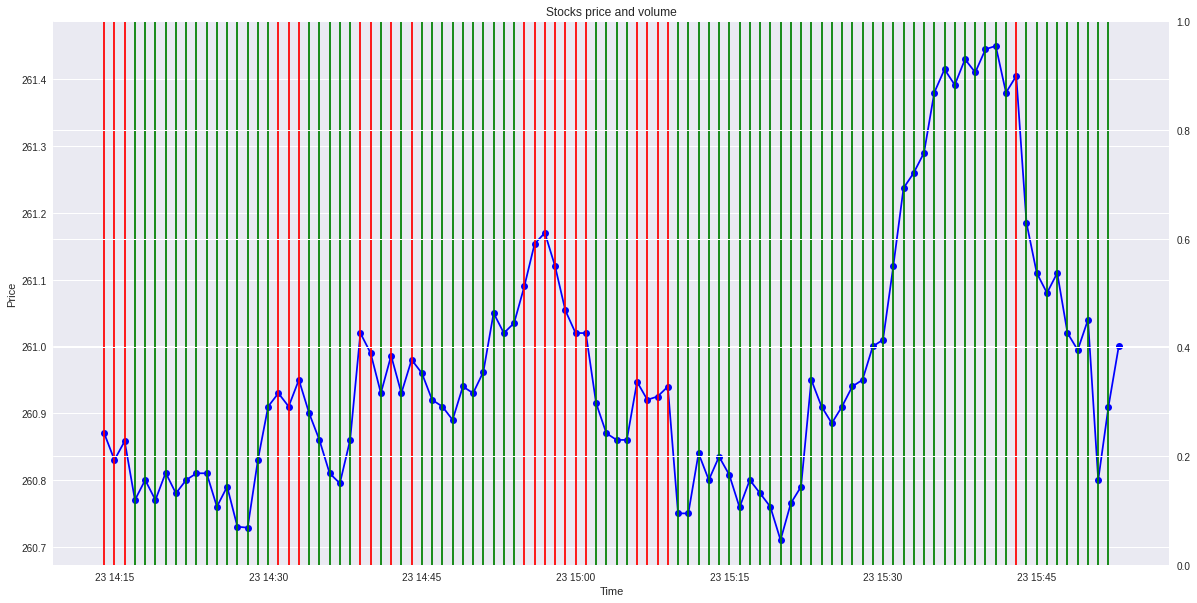

In [74]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.3. LSTM Classifier 2

In [75]:
LSTM_model = load_model('./SavedModels/LSTM_Classifier_best_model_3_69.h5')

In [76]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [77]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [78]:
LSTM_model_predictions

array([[0.7158507 ],
       [0.738831  ],
       [0.7445101 ],
       ...,
       [0.39069822],
       [0.28878725],
       [0.0563798 ]], dtype=float32)

In [79]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [80]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.4005796848910613
Mean Squared Error: 0.19813059610568967
Root Mean Squared Error: 0.44511863149691866


In [81]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [82]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.6919018123422803
PRECISION:  0.7137200093174936
RECALL:  0.6777261667772617


In [83]:
models_acc['LSTM_Classifier_Model_2'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681, 'LSTM_Model_2': 0.5950441665710681, 'LSTM_Model_3': 0.6004359297923597, 'Bi_LSTM_Model_1': 0.6279683377308707, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803}


Text(0.5, 1.0, '')

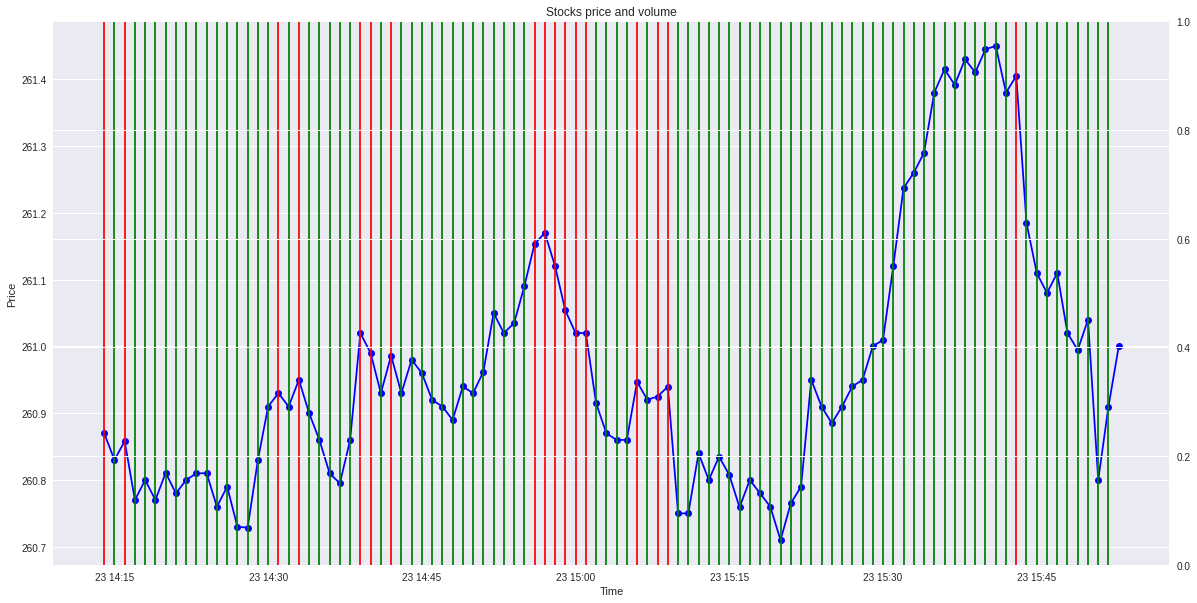

In [84]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.4. LSTM Classifier 3

In [85]:
LSTM_model = load_model('./SavedModels/LSTM_Classifier_best_model_4_69_6.h5')

In [86]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16, 50)            10400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [87]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [88]:
LSTM_model_predictions

array([[0.8100693 ],
       [0.8441447 ],
       [0.8710364 ],
       ...,
       [0.39421695],
       [0.30154395],
       [0.08621246]], dtype=float32)

In [89]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [90]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.3957246527277458
Mean Squared Error: 0.1962986859784699
Root Mean Squared Error: 0.44305607543342623


In [91]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [92]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.6960311998164717
PRECISION:  0.7365478686233403
RECALL:  0.6754966887417219


In [93]:
models_acc['LSTM_Classifier_Model_3'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681, 'LSTM_Model_2': 0.5950441665710681, 'LSTM_Model_3': 0.6004359297923597, 'Bi_LSTM_Model_1': 0.6279683377308707, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717}


Text(0.5, 1.0, '')

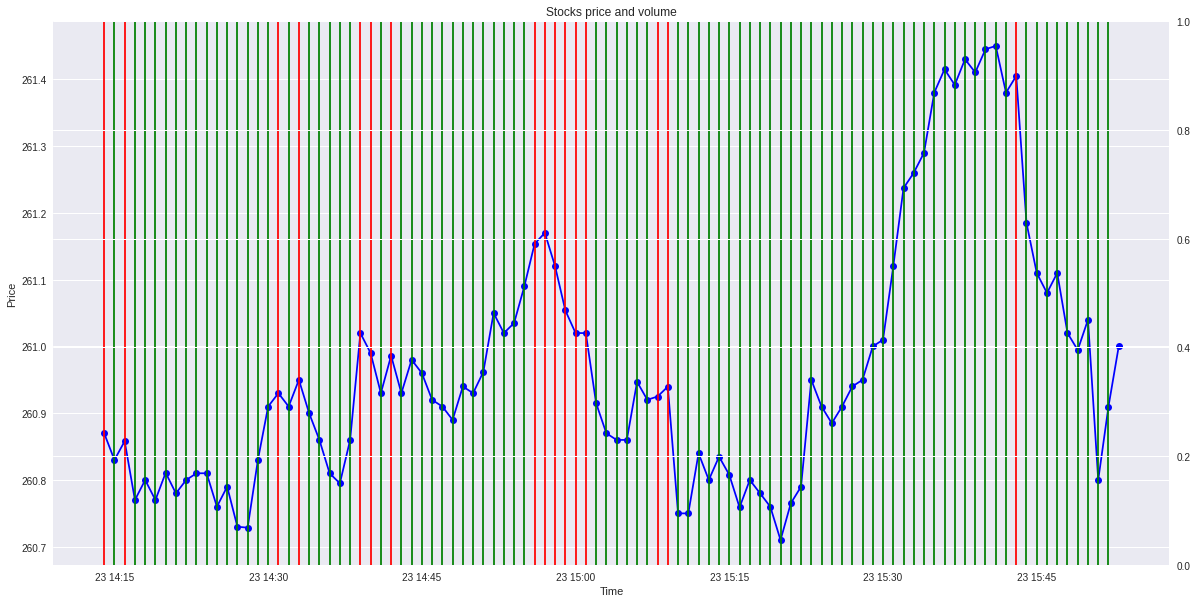

In [94]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.5. Bidirectional LSTM Classifier 1

In [95]:
LSTM_model = load_model('./SavedModels/BI_LSTM_best_model_1.h5')

In [96]:
LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 16, 100)           40800     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 16, 128)           84480     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 174,753
Trainable params: 174,753
Non-trainable params: 0
_________________________________________________________________


In [97]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [98]:
LSTM_model_predictions

array([[ 1.0212704],
       [ 1.0279839],
       [ 1.000201 ],
       ...,
       [-1.4354919],
       [-1.4290127],
       [-1.4272866]], dtype=float32)

In [99]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [100]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.9278137267651184
Mean Squared Error: 1.4386761466473201
Root Mean Squared Error: 1.1994482675994493


In [101]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [102]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.503785271851342
PRECISION:  0.469601677148847
RECALL:  0.4959409594095941


In [103]:
models_acc['BI_LSTM_Classifier_Model_1'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681, 'LSTM_Model_2': 0.5950441665710681, 'LSTM_Model_3': 0.6004359297923597, 'Bi_LSTM_Model_1': 0.6279683377308707, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717, 'BI_LSTM_Classifier_Model_1': 0.503785271851342}


Text(0.5, 1.0, '')

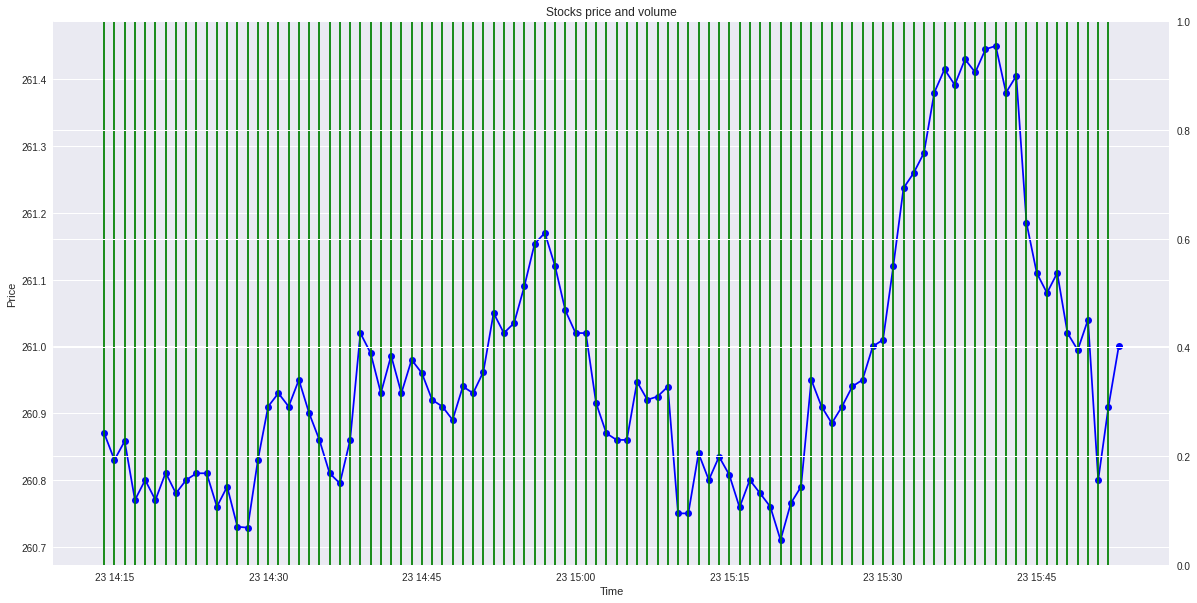

In [104]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.6. Bidirectional LSTM Classifier 2

In [105]:
LSTM_model = load_model('./SavedModels/BI_LSTM_Classifier_best_model_1_68_5.h5')

In [106]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 50)            10400     
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 50,901
Trainable params: 50,901
Non-trainable params: 0
_________________________________________________________________


In [107]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [108]:
LSTM_model_predictions

array([[0.73926806],
       [0.77508795],
       [0.780411  ],
       ...,
       [0.32331827],
       [0.24972352],
       [0.01997173]], dtype=float32)

In [109]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [110]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.4018096513063379
Mean Squared Error: 0.20344356628434823
Root Mean Squared Error: 0.45104718853391407


In [111]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [112]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.6853636155081441
PRECISION:  0.5844397856976473
RECALL:  0.7234717416378316


In [113]:
models_acc['BI_LSTM_Classifier_Model_2'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681, 'LSTM_Model_2': 0.5950441665710681, 'LSTM_Model_3': 0.6004359297923597, 'Bi_LSTM_Model_1': 0.6279683377308707, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717, 'BI_LSTM_Classifier_Model_1': 0.503785271851342, 'BI_LSTM_Classifier_Model_2': 0.6853636155081441}


Text(0.5, 1.0, '')

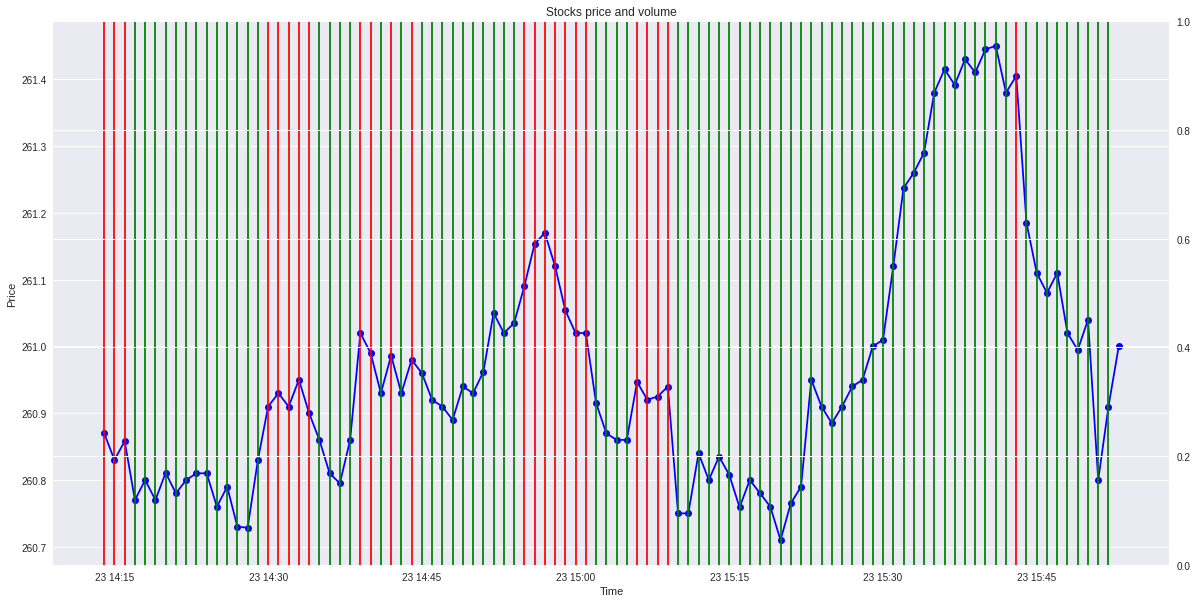

In [114]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.7. Bidirectional LSTM Classifier 3

In [115]:
LSTM_model = load_model('./SavedModels/BI_LSTM_Classifier_best_model_1_70.h5')

In [116]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16, 50)            10400     
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 50,901
Trainable params: 50,901
Non-trainable params: 0
_________________________________________________________________


In [117]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [118]:
LSTM_model_predictions

array([[0.7911258 ],
       [0.8064668 ],
       [0.81937563],
       ...,
       [0.43235356],
       [0.38728493],
       [0.18053202]], dtype=float32)

In [119]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [120]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.391414482224272
Mean Squared Error: 0.19566539260709304
Root Mean Squared Error: 0.44234081046981527


In [121]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [122]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.6992429456297315
PRECISION:  0.7211740041928721
RECALL:  0.6848042468480424


In [123]:
models_acc['BI_LSTM_Classifier_Model_3'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681, 'LSTM_Model_2': 0.5950441665710681, 'LSTM_Model_3': 0.6004359297923597, 'Bi_LSTM_Model_1': 0.6279683377308707, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717, 'BI_LSTM_Classifier_Model_1': 0.503785271851342, 'BI_LSTM_Classifier_Model_2': 0.6853636155081441, 'BI_LSTM_Classifier_Model_3': 0.6992429456297315}


Text(0.5, 1.0, '')

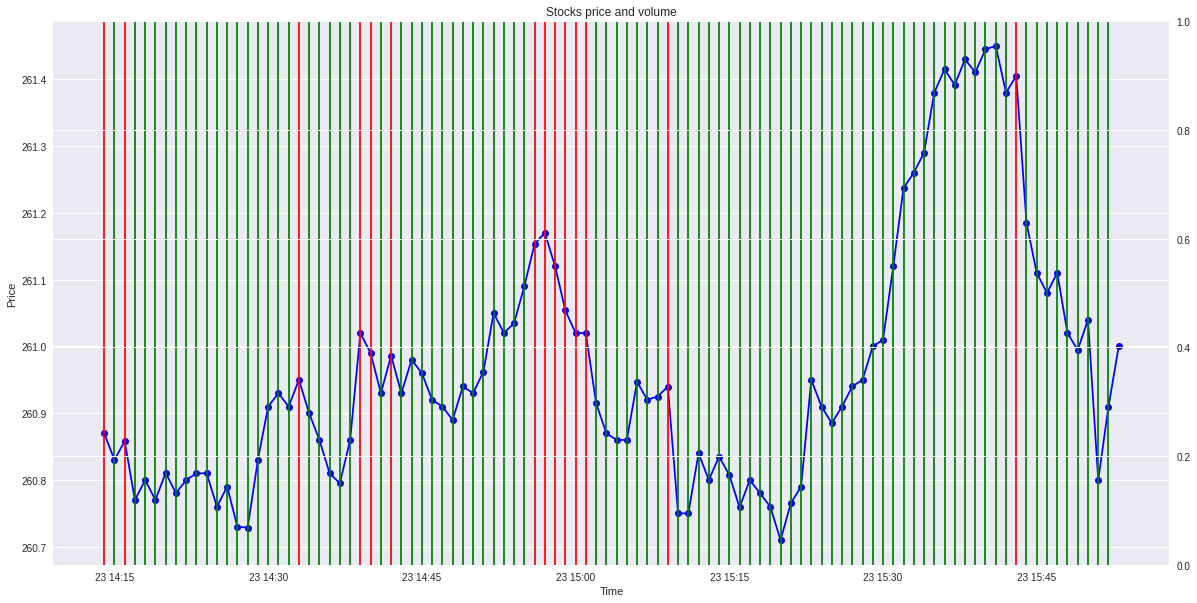

In [124]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.8. Bidirectional LSTM Classifier 4

In [125]:
LSTM_model = load_model('./SavedModels/BI_LSTM_Classifier_best_model_2_68_66.h5')

In [126]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16, 50)            10400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 100)           40400     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 111,301
Trainable params: 111,301
Non-trainable params: 0
_________________________________________________________________


In [127]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [128]:
LSTM_model_predictions

array([[0.6689186 ],
       [0.6806824 ],
       [0.7227184 ],
       ...,
       [0.44132593],
       [0.34601337],
       [0.18716696]], dtype=float32)

In [129]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [130]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.40760703401883197
Mean Squared Error: 0.2005258382689456
Root Mean Squared Error: 0.4478011146356668


In [131]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [132]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.6866253727919247
PRECISION:  0.5981830887491265
RECALL:  0.7183216783216784


In [133]:
models_acc['BI_LSTM_Classifier_Model_4'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681, 'LSTM_Model_2': 0.5950441665710681, 'LSTM_Model_3': 0.6004359297923597, 'Bi_LSTM_Model_1': 0.6279683377308707, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717, 'BI_LSTM_Classifier_Model_1': 0.503785271851342, 'BI_LSTM_Classifier_Model_2': 0.6853636155081441, 'BI_LSTM_Classifier_Model_3': 0.6992429456297315, 'BI_LSTM_Classifier_Model_4': 0.6866253727919247}


Text(0.5, 1.0, '')

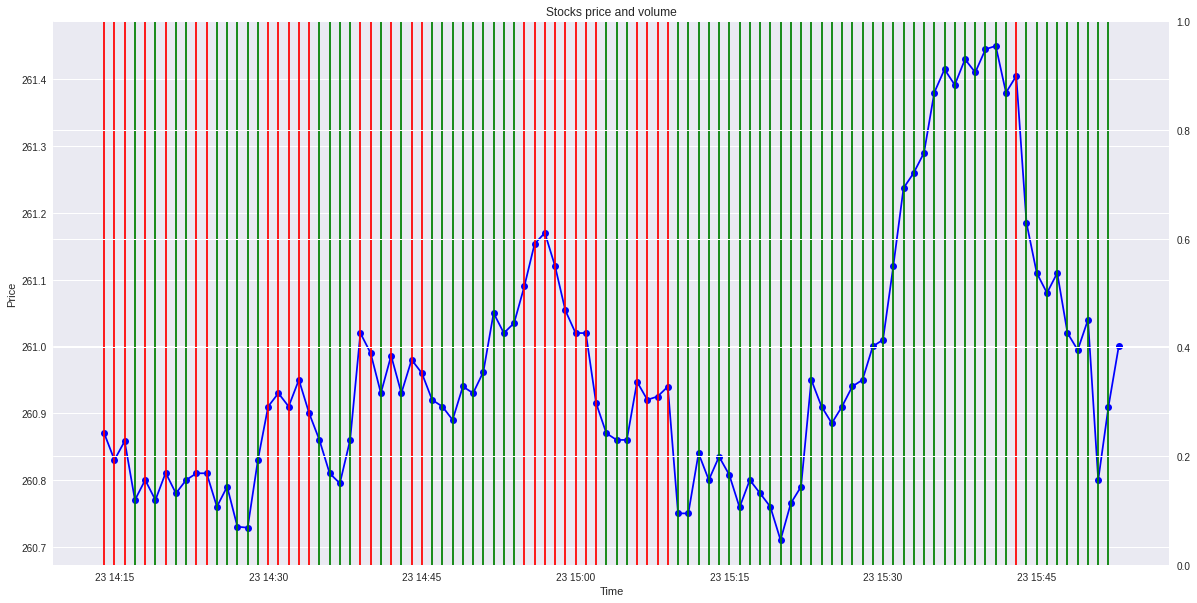

In [134]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.9. Bidirectional LSTM Classifier 5

In [135]:
LSTM_model = load_model('./SavedModels/BI_LSTM_Classifier_best_model_3_69_4.h5')

In [136]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16, 50)            10400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 100)           40400     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 111,301
Trainable params: 111,301
Non-trainable params: 0
_________________________________________________________________


In [137]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [138]:
LSTM_model_predictions

array([[0.7946126 ],
       [0.82120174],
       [0.8297181 ],
       ...,
       [0.40914786],
       [0.29947537],
       [0.14271198]], dtype=float32)

In [139]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [140]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.3856428196364435
Mean Squared Error: 0.19517335984356224
Root Mean Squared Error: 0.44178429107830697


In [141]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [142]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.694769442532691
PRECISION:  0.6738877242021896
RECALL:  0.696437168993741


In [143]:
models_acc['BI_LSTM_Classifier_Model_5'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681, 'LSTM_Model_2': 0.5950441665710681, 'LSTM_Model_3': 0.6004359297923597, 'Bi_LSTM_Model_1': 0.6279683377308707, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717, 'BI_LSTM_Classifier_Model_1': 0.503785271851342, 'BI_LSTM_Classifier_Model_2': 0.6853636155081441, 'BI_LSTM_Classifier_Model_3': 0.6992429456297315, 'BI_LSTM_Classifier_Model_4': 0.6866253727919247, 'BI_LSTM_Classifier_Model_5': 0.694769442532691}


Text(0.5, 1.0, '')

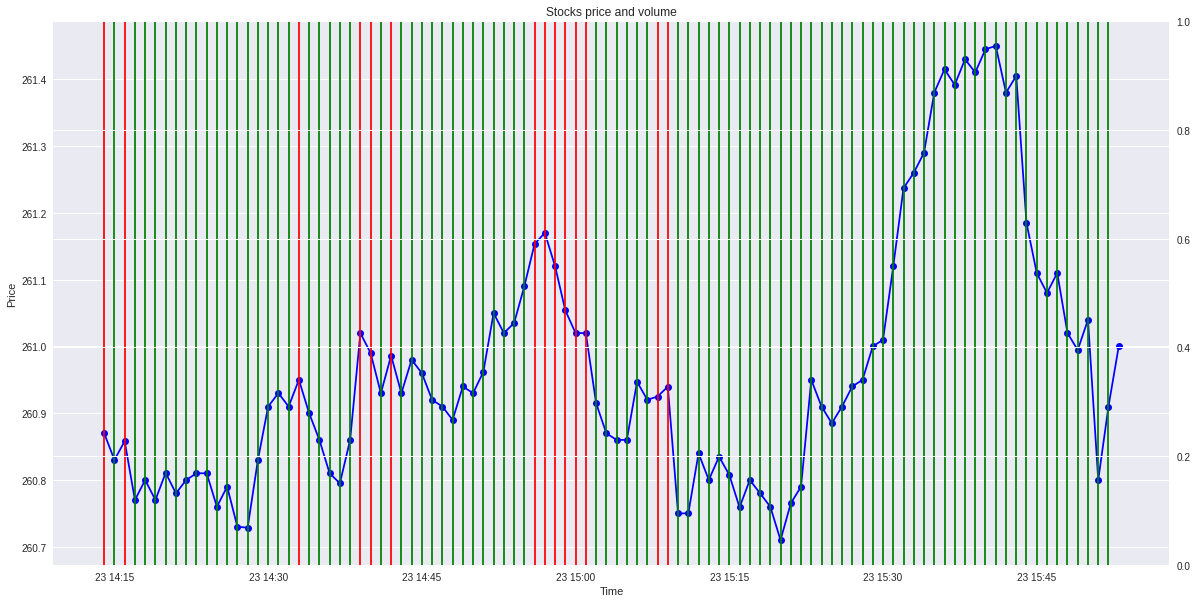

In [144]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## 4.2.10. Bidirectional LSTM Classifier 6

In [145]:
LSTM_model = load_model('./SavedModels/BI_LSTM_Classifier_best_model_3_70_6.h5')

In [146]:
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 16, 50)            10400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16, 100)           40400     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 111,301
Trainable params: 111,301
Non-trainable params: 0
_________________________________________________________________


In [147]:
LSTM_model_predictions = LSTM_model.predict(X_matrix)

In [148]:
LSTM_model_predictions

array([[0.6549171 ],
       [0.70140064],
       [0.66910267],
       ...,
       [0.2902843 ],
       [0.22368859],
       [0.03153574]], dtype=float32)

In [149]:
y

array([0, 1, 1, ..., 1, 0, 0])

In [150]:
print('FOR NORMALIZED PRICES')
print('Mean Absolute Error:', metrics.mean_absolute_error(y, LSTM_model_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y, LSTM_model_predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, LSTM_model_predictions)))

FOR NORMALIZED PRICES
Mean Absolute Error: 0.3807348651291444
Mean Squared Error: 0.192495792546068
Root Mean Squared Error: 0.43874342450465054


In [151]:
LSTM_model_predictions = np.array(list(map(lambda x: 0 if x < 0.5 else 1, LSTM_model_predictions)))
LSTM_model_predictions

array([1, 1, 1, ..., 0, 0, 0])

In [152]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(LSTM_model_predictions, y))
print('PRECISION: ', metrics.precision_score(LSTM_model_predictions, y))
print('RECALL: ', metrics.recall_score(LSTM_model_predictions, y))

METRICS ON PREDICTIONS
ACCURACY:  0.7061252580867171
PRECISION:  0.6165851385977172
RECALL:  0.7429132753297782


In [153]:
models_acc['BI_LSTM_Classifier_Model_6'] = metrics.accuracy_score(LSTM_model_predictions, y)
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681, 'LSTM_Model_2': 0.5950441665710681, 'LSTM_Model_3': 0.6004359297923597, 'Bi_LSTM_Model_1': 0.6279683377308707, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717, 'BI_LSTM_Classifier_Model_1': 0.503785271851342, 'BI_LSTM_Classifier_Model_2': 0.6853636155081441, 'BI_LSTM_Classifier_Model_3': 0.6992429456297315, 'BI_LSTM_Classifier_Model_4': 0.6866253727919247, 'BI_LSTM_Classifier_Model_5': 0.694769442532691, 'BI_LSTM_Classifier_Model_6': 0.7061252580867171}


Text(0.5, 1.0, '')

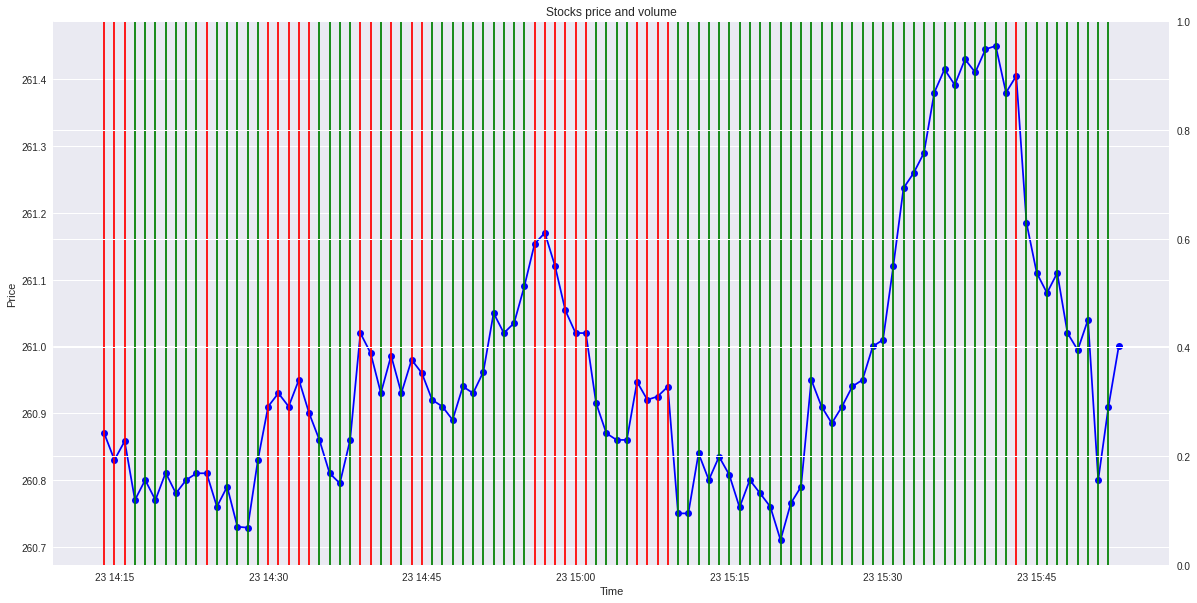

In [154]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], stock['close'][:100], label='Close price', marker = 'o', color='b')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if LSTM_model_predictions[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

## Transformer model

## TimeVector

In [155]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [156]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

In [157]:
model = load_model(
    './SavedModels/Transformer_acc_57.h5',
    custom_objects={
        'Time2Vector': Time2Vector, 
        'SingleAttention': SingleAttention,
        'MultiAttention': MultiAttention,
        'TransformerEncoder': TransformerEncoder
    }
)

In [158]:
stock.head()

,time,open,high,low,close,volume,company,price_1_min_ahead,price_2_min_ahead,price_3_min_ahead,...,EMA,MACD,MACD_Signal,change,gain,loss,avg_gain,avg_loss,rs,RSI
0,2021-04-23 15:53:00,260.93,261.11,260.890,261.0000,105102,MSFT,260.93,261.18,261.05,...,261.146603,-0.133621,-0.145338,0.0700,0.07,0.0000,0.029490,0.063490,0.464483,31.716498
1,2021-04-23 15:52:00,260.81,260.98,260.810,260.9100,82132,MSFT,261.00,260.93,261.18,...,261.124069,-0.136377,-0.143545,-0.0900,0.00,0.0900,0.028015,0.064815,0.432235,30.179035
2,2021-04-23 15:51:00,261.05,261.17,260.800,260.8000,136199,MSFT,260.91,261.00,260.93,...,261.093205,-0.145757,-0.143988,-0.1100,0.00,0.1100,0.026615,0.067075,0.396792,28.407387
3,2021-04-23 15:50:00,261.01,261.09,261.005,261.0400,50257,MSFT,260.80,260.91,261.00,...,261.088138,-0.132300,-0.141650,0.2400,0.24,0.0000,0.037284,0.063721,0.585113,36.913021
4,2021-04-23 15:49:00,261.02,261.08,260.990,260.9946,56559,MSFT,261.04,260.80,260.91,...,261.079230,-0.123870,-0.138094,-0.0454,0.00,0.0454,0.035420,0.062805,0.563965,36.059951


In [159]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [160]:
df = stock[['time','open','high','low','close','volume']]
df.head()

,time,open,high,low,close,volume
0,2021-04-23 15:53:00,260.93,261.11,260.890,261.0000,105102
1,2021-04-23 15:52:00,260.81,260.98,260.810,260.9100,82132
2,2021-04-23 15:51:00,261.05,261.17,260.800,260.8000,136199
3,2021-04-23 15:50:00,261.01,261.09,261.005,261.0400,50257
4,2021-04-23 15:49:00,261.02,261.08,260.990,260.9946,56559


In [161]:
# Replace 0 to avoid dividing by 0 later on
df['volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('time', inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].rolling(10).mean() 

# Drop all rows with NaN values
df.dropna(how='any', axis=0, inplace=True) 
df.head()

,time,open,high,low,close,volume
8708,2021-03-25 08:49:00,235.115,235.32008,235.00839,235.15008,2274.0
8707,2021-03-25 08:54:00,235.160,235.37008,235.07439,235.20108,2203.8
8706,2021-03-25 08:59:00,235.229,235.34208,235.14700,235.26808,2031.3
8705,2021-03-25 09:01:00,235.298,235.43508,235.20200,235.33608,2178.8
8704,2021-03-25 09:04:00,235.366,235.51208,235.28100,235.41508,2325.5


In [162]:
'''Calculate percentage change'''

df['open'] = df['open'].pct_change() # Create arithmetic returns column
df['high'] = df['high'].pct_change() # Create arithmetic returns column
df['low'] = df['low'].pct_change() # Create arithmetic returns column
df['close'] = df['close'].pct_change() # Create arithmetic returns column
df['volume'] = df['volume'].pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Normalize price columns'''

min_return = min(df[['open', 'high', 'low', 'close']].min(axis=0))
max_return = max(df[['open', 'high', 'low', 'close']].max(axis=0))

# Min-max normalize price columns (0-1 range)
df['open'] = (df['open'] - min_return) / (max_return - min_return)
df['high'] = (df['high'] - min_return) / (max_return - min_return)
df['low'] = (df['low'] - min_return) / (max_return - min_return)
df['close'] = (df['close'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''

min_volume = df['volume'].min(axis=0)
max_volume = df['volume'].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df['volume'] = (df['volume'] - min_volume) / (max_volume - min_volume)

In [163]:
df.head()

,time,open,high,low,close,volume
8707,2021-03-25 08:54:00,0.437425,0.444115,0.465809,0.445513,0.018558
8706,2021-03-25 08:59:00,0.469800,0.338938,0.474707,0.467085,0.017635
8705,2021-03-25 09:01:00,0.469773,0.502089,0.450912,0.468408,0.020573
8704,2021-03-25 09:04:00,0.468397,0.480474,0.483275,0.483215,0.020470
8703,2021-03-25 09:17:00,0.386126,0.382078,0.369945,0.396908,0.021588


In [164]:
df.drop(columns=['time'], inplace=True)

In [165]:
df[seq_len:]

,open,high,low,close,volume
8579,0.317942,0.302944,0.285795,0.289703,0.021134
8578,0.288552,0.339125,0.306961,0.363021,0.019926
8577,0.363020,0.432700,0.371219,0.414960,0.022623
8576,0.420429,0.450446,0.431390,0.431355,0.019280
8575,0.434090,0.442236,0.434115,0.449110,0.019193
...,...,...,...,...,...
4,0.328111,0.325314,0.328095,0.326196,0.019307
3,0.328103,0.327394,0.327480,0.327488,0.018775
2,0.326881,0.335391,0.298308,0.297713,0.021612
1,0.298928,0.317164,0.308012,0.319569,0.020006


In [166]:
train_data = df.values

In [167]:
X, y = [], []
for i in range(seq_len, len(train_data)):
  X.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
    

In [168]:
X, y = np.array(X), np.array(y)

In [169]:
pred = model.predict(X)

In [170]:
zpred = np.array(list(map(float, pred)))

In [171]:
real_label = get_trades(y[:-1],y[1:])
pred_label = get_trades(y[:-1],zpred[1:])

In [172]:
min(pred),max(pred),np.mean(pred)

(array([0.26820302], dtype=float32),
 array([0.5627973], dtype=float32),
 0.38047463)

Text(0.5, 1.0, '')

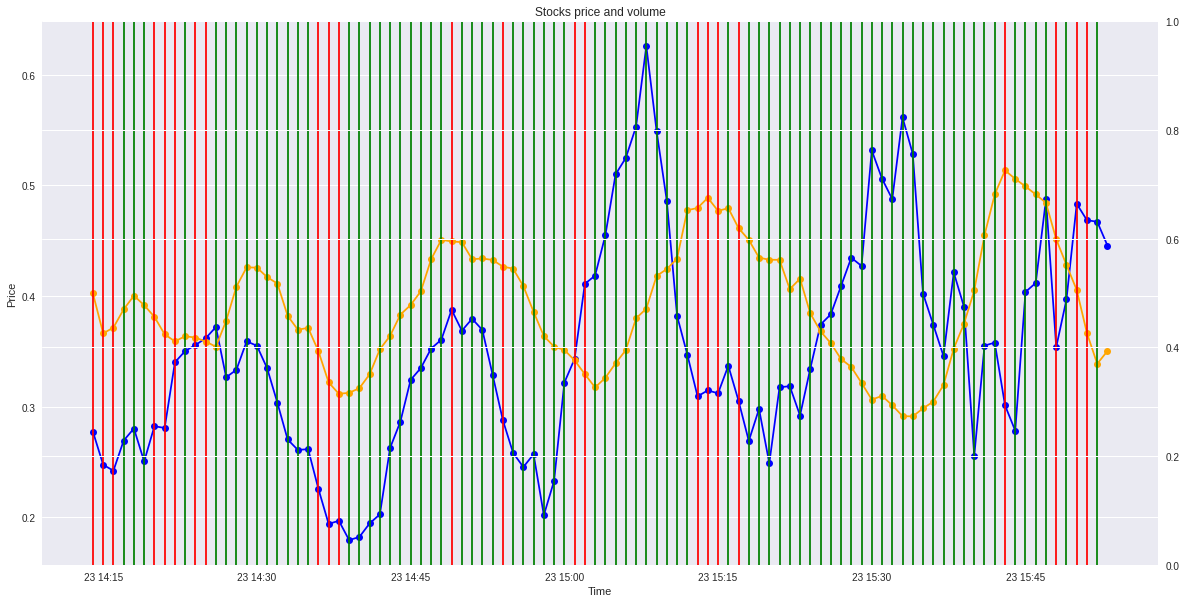

In [173]:
# Visualize orders placed by model
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()  # set up the 2nd axis
    
ax1.set_xlabel("Time")
ax1.set_ylabel("Price")
ax1.set_title(f'Stocks price and volume')
    
ax1.plot(stock['time'][:100], df['close'][:100], label='Close price', marker = 'o', color='b')
ax1.plot(stock['time'][:100], zpred[:100], label='Predcitions', marker = 'o', color='orange')

for order in range(1, 100):
    
    # GREEN line for higher predcition
    if pred_label[order] == 1:
        ax1.axvline(x=stock['time'][order], c = "green")
        
    # RED line for lower prediction
    else:
        ax1.axvline(x=stock['time'][order], c = "red")

plt.title("")

In [174]:
tacc = metrics.accuracy_score(real_label,pred_label)
tacc

0.5704627578971908

In [175]:
print('METRICS ON PREDICTIONS')
print('ACCURACY: ', metrics.accuracy_score(pred_label, real_label))
print('PRECISION: ', metrics.precision_score(pred_label, real_label))
print('RECALL: ', metrics.recall_score(pred_label, real_label))

METRICS ON PREDICTIONS
ACCURACY:  0.5704627578971908
PRECISION:  0.5255769688317868
RECALL:  0.5664102564102564


In [176]:
models_acc['Transformer'] = tacc
print(models_acc)

{'LSTM_Model_1': 0.5950441665710681, 'LSTM_Model_2': 0.5950441665710681, 'LSTM_Model_3': 0.6004359297923597, 'Bi_LSTM_Model_1': 0.6279683377308707, 'LSTM_Classifier_Model_1': 0.6819224592796513, 'LSTM_Classifier_Model_2': 0.6919018123422803, 'LSTM_Classifier_Model_3': 0.6960311998164717, 'BI_LSTM_Classifier_Model_1': 0.503785271851342, 'BI_LSTM_Classifier_Model_2': 0.6853636155081441, 'BI_LSTM_Classifier_Model_3': 0.6992429456297315, 'BI_LSTM_Classifier_Model_4': 0.6866253727919247, 'BI_LSTM_Classifier_Model_5': 0.694769442532691, 'BI_LSTM_Classifier_Model_6': 0.7061252580867171, 'Transformer': 0.5704627578971908}


---

# 5. Find best model after backtest

## 5.1. Find model with highest accuracy

In [177]:
highest_acc = 0
highest_acc_model = ''
for model in models_acc:
    acc = models_acc[model]
    if acc > highest_acc:
        highest_acc = acc
        highest_acc_model = model
#     print(model, acc)
print(highest_acc_model, highest_acc)

BI_LSTM_Classifier_Model_6 0.7061252580867171


## 5.2. Predicted returns with best model

In [178]:
return_prct = (highest_acc * 100 * 1.5) - 100
print(f'Returns with model {highest_acc_model} = {return_prct} %')

Returns with model BI_LSTM_Classifier_Model_6 = 5.918788713007558 %


---